In [1]:
import torch  
import torchvision  
from torchvision import datasets, transforms, models  
from torch.utils.data import DataLoader  
import torch.nn as nn  
import torch.optim as optim  
from tqdm import tqdm  # Ensure tqdm is imported  
import numpy as np  

In [2]:

data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'train': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [3]:
train_dir = '/kaggle/input/datasetflores-marco-laime-gonzales/Dataset Flores/train'

test_dir = '/kaggle/input/datasetflores-marco-laime-gonzales/Dataset Flores/test'

valid_dir = '/kaggle/input/datasetflores-marco-laime-gonzales/Dataset Flores/valid'  


# Cargar datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
}

# Cargar DataLoaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False)
}

# Número de clases
num_classes = len(image_datasets['train'].classes)
#num_classes = len(image_datasets['test'].classes)

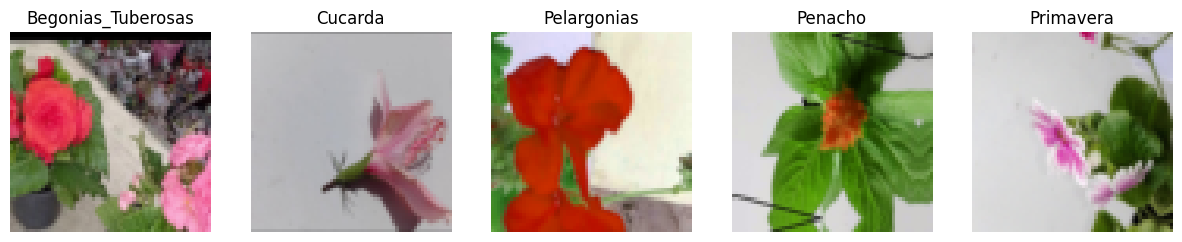

In [4]:
# Visualización de imágenes
import matplotlib.pyplot as plt
import random
classes = image_datasets['test'].classes
plt.figure(figsize=(15, 3))

# Obtener una imagen aleatoria por clase
for i, class_name in enumerate(classes):
    # Filtrar las imágenes que pertenecen a la clase actual
    class_indices = [idx for idx, (_, label) in enumerate(image_datasets['test'].imgs) if label == i]

    # Seleccionar un índice aleatorio de esta clase
    random_index = random.choice(class_indices)

    # Cargar la imagen correspondiente
    img, label = image_datasets['test'][random_index]

    # Convertir la imagen a un formato visible
    img = img.permute(1, 2, 0).numpy()  # Cambiar el orden de los ejes
    img = img * 0.5 + 0.5  # Desnormalizar la imagen

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_name)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [5]:

import torch  
from torchvision import models  

# Cargar el modelo preentrenado de ConvNext  
model = models.convnext_base(pretrained=True)  # Cambiar a convnext_small, convnext_large, etc., según necesites  
model.eval()

# Reemplazar la última capa con una nueva para 5 clases
num_classes = 5
in_features = model.classifier[2].in_features  # Obtener el número de entradas de la capa final
model.classifier[2] = nn.Linear(in_features, num_classes)  # Nueva capa de salida

# Ver modelo modificado
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:01<00:00, 208MB/s]


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

In [7]:
# Definir modelo con ConvNeXt
class ModelCustom(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=False, freeze=False):
        super().__init__()
        convnext = models.convnext_base(pretrained=pretrained)
        self.convnext = torch.nn.Sequential(*list(convnext.children())[:-1])
        if freeze:
            for param in self.convnext.parameters():
                param.requires_grad = False
        in_features = convnext.classifier[2].in_features
        self.fc = torch.nn.Linear(in_features, n_outputs)

    def forward(self, x):
        x = self.convnext(x)
        x = x.view(x.shape[0], -1) 
        x = self.fc(x)
        return x

    def unfreeze(self):
        for param in self.convnext.parameters():
            param.requires_grad = True


In [8]:
# Función de entrenamiento y validación
def fit(model, dataloader, epochs=5,lr_convnext=1e-4, lr_fc=1e-3,device='cuda'):
    model.to(device)
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    #     convnext = models.convnext_base(pretrained=pretrained)
    optimizer = optimizer = torch.optim.Adam([{'params': model.convnext.parameters(), 'lr': lr_convnext},{'params': model.fc.parameters(), 'lr': lr_fc}])
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            bar = tqdm(dataloader['valid'])
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")



In [9]:
model = ModelCustom(pretrained=True, freeze=True)
fit(model, dataloaders, epochs=20, lr_convnext=1e-4, lr_fc=1e-3,device=device)
model.unfreeze()
fit(model, dataloaders, lr_convnext=1e-4, lr_fc=1e-3)

val_loss 0.10572 val_acc 0.97370: 100%|██████████| 246/246 [01:59<00:00,  2.07it/s]


Epoch 1/20 loss 0.26324 val_loss 0.10572 acc 0.92442 val_acc 0.97370


val_loss 0.07514 val_acc 0.97967: 100%|██████████| 246/246 [01:00<00:00,  4.10it/s]


Epoch 2/20 loss 0.12554 val_loss 0.07514 acc 0.96362 val_acc 0.97967


val_loss 0.06133 val_acc 0.98501: 100%|██████████| 246/246 [00:55<00:00,  4.40it/s]


Epoch 3/20 loss 0.09920 val_loss 0.06133 acc 0.97055 val_acc 0.98501


val_loss 0.05703 val_acc 0.98349: 100%|██████████| 246/246 [00:55<00:00,  4.40it/s]


Epoch 4/20 loss 0.08913 val_loss 0.05703 acc 0.97337 val_acc 0.98349


val_loss 0.05041 val_acc 0.98603: 100%|██████████| 246/246 [01:08<00:00,  3.60it/s]


Epoch 5/20 loss 0.08062 val_loss 0.05041 acc 0.97476 val_acc 0.98603


val_loss 0.05041 val_acc 0.98501: 100%|██████████| 246/246 [00:55<00:00,  4.40it/s]


Epoch 6/20 loss 0.07494 val_loss 0.05041 acc 0.97707 val_acc 0.98501


val_loss 0.04421 val_acc 0.98692: 100%|██████████| 246/246 [00:58<00:00,  4.17it/s]


Epoch 7/20 loss 0.07282 val_loss 0.04421 acc 0.97821 val_acc 0.98692


val_loss 0.04232 val_acc 0.98819: 100%|██████████| 246/246 [00:55<00:00,  4.45it/s]


Epoch 8/20 loss 0.06916 val_loss 0.04232 acc 0.97748 val_acc 0.98819


val_loss 0.05196 val_acc 0.98399: 100%|██████████| 246/246 [01:10<00:00,  3.47it/s]


Epoch 9/20 loss 0.06568 val_loss 0.05196 acc 0.97975 val_acc 0.98399


val_loss 0.04551 val_acc 0.98577: 100%|██████████| 246/246 [01:15<00:00,  3.24it/s]


Epoch 10/20 loss 0.06292 val_loss 0.04551 acc 0.98015 val_acc 0.98577


val_loss 0.04035 val_acc 0.98844: 100%|██████████| 246/246 [01:01<00:00,  4.02it/s]


Epoch 11/20 loss 0.06506 val_loss 0.04035 acc 0.97957 val_acc 0.98844


val_loss 0.04029 val_acc 0.98819: 100%|██████████| 246/246 [01:04<00:00,  3.82it/s]


Epoch 12/20 loss 0.06181 val_loss 0.04029 acc 0.97987 val_acc 0.98819


val_loss 0.03975 val_acc 0.98857: 100%|██████████| 246/246 [01:00<00:00,  4.04it/s]


Epoch 13/20 loss 0.06037 val_loss 0.03975 acc 0.98055 val_acc 0.98857


val_loss 0.04099 val_acc 0.98780: 100%|██████████| 246/246 [00:58<00:00,  4.22it/s]


Epoch 14/20 loss 0.05946 val_loss 0.04099 acc 0.98061 val_acc 0.98780


val_loss 0.03933 val_acc 0.98742: 100%|██████████| 246/246 [01:08<00:00,  3.62it/s]


Epoch 15/20 loss 0.05868 val_loss 0.03933 acc 0.98112 val_acc 0.98742


val_loss 0.03809 val_acc 0.98908: 100%|██████████| 246/246 [00:56<00:00,  4.37it/s]


Epoch 16/20 loss 0.05643 val_loss 0.03809 acc 0.98221 val_acc 0.98908


val_loss 0.03719 val_acc 0.98869: 100%|██████████| 246/246 [00:57<00:00,  4.25it/s]


Epoch 17/20 loss 0.05753 val_loss 0.03719 acc 0.98161 val_acc 0.98869


val_loss 0.03502 val_acc 0.98946: 100%|██████████| 246/246 [01:14<00:00,  3.30it/s]


Epoch 18/20 loss 0.05568 val_loss 0.03502 acc 0.98238 val_acc 0.98946


val_loss 0.03455 val_acc 0.99022: 100%|██████████| 246/246 [01:02<00:00,  3.93it/s]


Epoch 19/20 loss 0.05625 val_loss 0.03455 acc 0.98170 val_acc 0.99022


val_loss 0.03862 val_acc 0.98793: 100%|██████████| 246/246 [01:03<00:00,  3.87it/s]


Epoch 20/20 loss 0.05576 val_loss 0.03862 acc 0.98200 val_acc 0.98793


val_loss 0.00632 val_acc 0.99835: 100%|██████████| 246/246 [01:01<00:00,  4.00it/s]


Epoch 1/5 loss 0.03639 val_loss 0.00632 acc 0.98904 val_acc 0.99835


val_loss 0.01457 val_acc 0.99593: 100%|██████████| 246/246 [01:10<00:00,  3.51it/s]


Epoch 2/5 loss 0.01124 val_loss 0.01457 acc 0.99657 val_acc 0.99593


val_loss 0.01372 val_acc 0.99593: 100%|██████████| 246/246 [01:03<00:00,  3.88it/s]


Epoch 3/5 loss 0.01330 val_loss 0.01372 acc 0.99627 val_acc 0.99593


val_loss 0.01333 val_acc 0.99568: 100%|██████████| 246/246 [01:01<00:00,  3.98it/s]


Epoch 4/5 loss 0.00768 val_loss 0.01333 acc 0.99782 val_acc 0.99568


val_loss 0.01120 val_acc 0.99708: 100%|██████████| 246/246 [01:01<00:00,  4.01it/s]

Epoch 5/5 loss 0.00529 val_loss 0.01120 acc 0.99848 val_acc 0.99708


In [10]:
# Inicializar modelo
#model = ModelCustom(pretrained=True,freeze=True)  

# Entrenar modelo
#fit(model, dataloaders, epochs=50, lr=1e-2,device=device)

In [11]:
import torch  
import torch.nn as nn  

# Assuming you have already set up your model, dataloaders, optimizer, and device  

# Define the criterion  
criterion = nn.CrossEntropyLoss()  # or your specific loss function  

import torch.optim as optim  

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Ajusta el learning rate como necesites 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

Ejemplo:
Epoch 10/10 loss 0.82109 acc 0.69234 val_loss 0.66147 val_acc 0.75622

train_losses = []  
train_accuracies = []  
valid_losses = []  
valid_accuracies = []  


NameError: name 'train_losses' is not defined

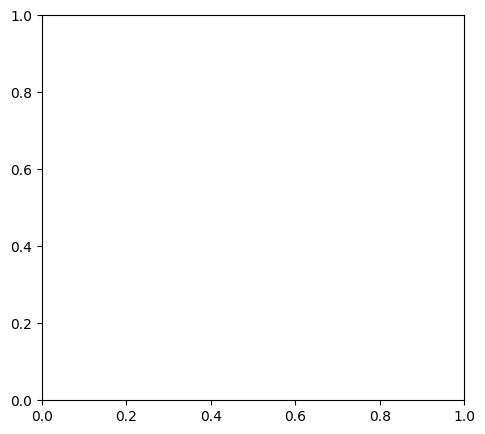

In [12]:
import matplotlib.pyplot as plt  

# Graficar pérdidas  
plt.figure(figsize=(12, 5))  

# Pérdida  
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, 1ª gráfica  
plt.plot(range(1, len(train_losses) + 1), train_losses, label='loss', marker='o')  
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='val_loss', marker='o')  
plt.title('Pérdida por época')  
plt.xlabel('Épocas')  
plt.ylabel('Pérdida')  
plt.legend()  
plt.grid()  

# Precisión  
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, 2ª gráfica  
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='acc', marker='o')  
plt.plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label='val_acc', marker='o')  
plt.title('Precisión por época')  
plt.xlabel('Épocas')  
plt.ylabel('Precisión')  
plt.legend()  
plt.grid()  

plt.show()

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

    accuracy = correct.double() / total
    print(f'Accuracy on test set: {accuracy:.4f}')

evaluate_model(model, dataloaders['test'])